In [ ]:
import numpy as np
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGridMapper
from sionna.utils import BinarySource
from sionna.ofdm import ResourceGrid
import matplotlib.pyplot as plt
import numpy as np
from sionna.channel.tr38901 import Antenna
from sionna.ofdm import ResourceGridMapper, LSChannelEstimator, LMMSEInterpolator
from sionna.utils import BinarySource
from sionna.mapping import Mapper
from sionna.channel import GenerateOFDMChannel, gen_single_sector_topology
from sionna.channel.tr38901 import UMi, Antenna, PanelArray
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange
import tensorflow as tf
import sionna
import torch

In [ ]:
num_ofdm_symbols = 8
fft_size = 32
num_effective_subcarriers = fft_size
num_tx = 1
cyclic_prefix_length = 0
subcarrier_spacing = 30e3
pilot_pattern = "kronecker"
pilot_ofdm_symbol_indices = [2, 6]
num_bits_per_symbol = 2

In [ ]:
rg = ResourceGrid(
    num_ofdm_symbols=num_ofdm_symbols,
    fft_size=fft_size,
    num_tx=num_tx,
    cyclic_prefix_length=cyclic_prefix_length,
    subcarrier_spacing=subcarrier_spacing,
    pilot_pattern=pilot_pattern,
    pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices,
)


rg_mapper = ResourceGridMapper(rg)
binary_source = BinarySource()
mapper = Mapper(constellation_type="qam", num_bits_per_symbol=num_bits_per_symbol)

# Number of information bits per codeword
inf_bpc = int(rg.num_data_symbols * num_bits_per_symbol)

b_input = binary_source([1, num_tx, 1, inf_bpc])

x_out = mapper(b_input)

x_rg = rg_mapper(x_out)
x_rg = x_rg.numpy()
x_rg = np.reshape(x_rg, (num_ofdm_symbols, num_effective_subcarriers))

# get mask of pilot pattern
masks = rg.pilot_pattern.mask
masks = np.reshape(masks, (num_ofdm_symbols, num_effective_subcarriers))

# return only pilots values
x_signal = x_rg * masks
# x_signal = x_rg

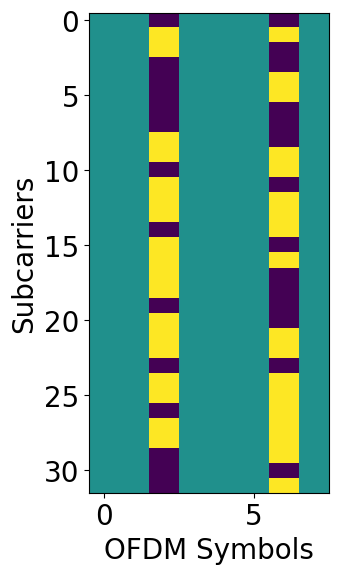

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width

# Assuming x_signal is a 2D array
# Display the array as an image
plt.imshow(x_signal.real.T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()


In [ ]:
subcarries_spacing = 30e3 # Hz
carrier_frequency = 3.5e9 # Hz

In [ ]:
# The user terminals (UTs) are equipped with a single antenna
# with vertial polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni', # Omnidirectional antenna pattern
                     carrier_frequency=carrier_frequency)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
BS_ARRAY = PanelArray(num_rows_per_panel=1,
                        num_cols_per_panel=4,
                        polarization='single',
                        polarization_type='V',
                        antenna_pattern='38.901', # 3GPP 38.901 antenna pattern
                        carrier_frequency=carrier_frequency)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=carrier_frequency,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=True)

channel_sampler = GenerateOFDMChannel(CHANNEL_MODEL, rg, normalize_channel=True)

In [ ]:
# Sample random topologies
topology = gen_single_sector_topology(1, 1, 'umi',
                                      min_ut_velocity=0., max_ut_velocity=0.)
ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology
CHANNEL_MODEL.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state)


# Sample channel frequency responses
# [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, num_effective_subcarriers]
h_freq = channel_sampler(1000)
# [batch size, num_rx_ant, num_ofdm_symbols, num_effective_subcarriers]
h_freq = h_freq[:,0,:,0,0]
# convert to numpy
h_freq.shape

TensorShape([1, 4, 8, 32])

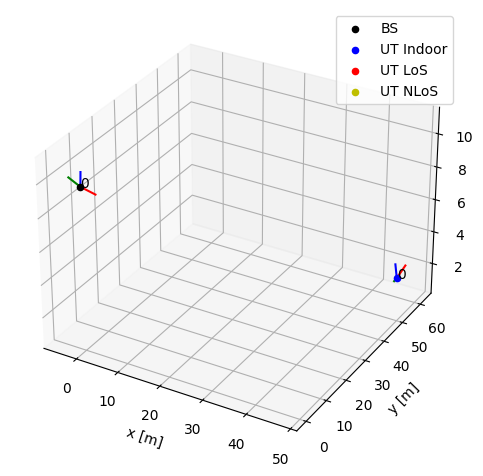

In [ ]:
CHANNEL_MODEL.show_topology()

In [ ]:
import gdown
import pickle
import numpy as np
def download_and_load_pkl(url, output='output.pkl'):
    # Download the pickle file from Google Drive
    # gdown.download(url, output, quiet=False)

    # Load the pickle file
    with open(output, 'rb') as f:
        data = pickle.load(f)

    return data

def load_topology(filename):
    with open('topology.pkl', 'rb') as f:
      loaded_topology = pickle.load(f)

    # Convert all numpy arrays to TensorFlow tensors
    for key, value in loaded_topology.items():
        loaded_topology[key] = tf.convert_to_tensor(value)

    return loaded_topology

def sample_channel_1(batch_size):
    topology = download_and_load_pkl(
        "https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S",
        output="topology.pkl",
    )

    values_topology = list(load_topology(topology).values())
    CHANNEL_MODEL.set_topology(*values_topology)

    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, fft_size]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
    h_freq = h_freq[:,0,:,0,0]
    return h_freq.numpy()


def sample_channel_2(batch_size):
    topology = gen_single_sector_topology(1000, 1, 'umi',
                                      min_ut_velocity=0., max_ut_velocity=0.)
    CHANNEL_MODEL.set_topology(*topology)


    # Sample channel frequency responses
    # [batch size, 1, num_rx_ant, 1, 1, num_ofdm_symbols, num_effective_subcarriers]
    h_freq = channel_sampler(batch_size)
    # [batch size, num_rx_ant, num_ofdm_symbols, num_effective_subcarriers]
    h_freq = h_freq[:,0,:,0,0]
    # convert to numpy
    h_freq = h_freq.numpy()
    return h_freq


In [ ]:
h_freq = sample_channel_1(1)

In [ ]:
h_freq.shape

(1, 4, 8, 32)

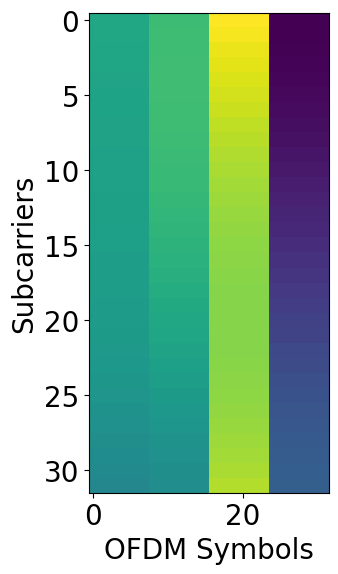

In [ ]:
# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow(h_freq[0].reshape(32,32).real.T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

[<tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[60.78135 , 21.858072,  1.5     ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[ 0.,  0., 10.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[ 0.14317858, -0.18755949, -0.928191  ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[1.0471976 , 0.17985356, 0.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[-0., -0.,  0.]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>]


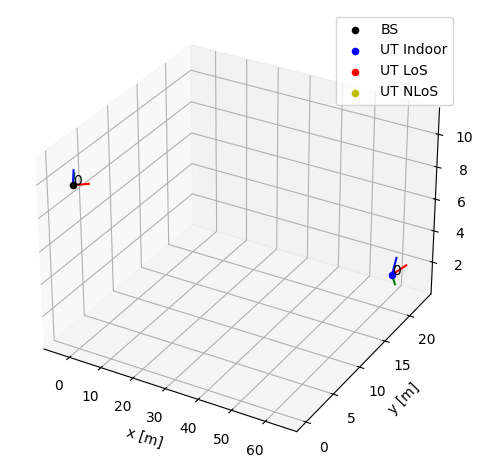

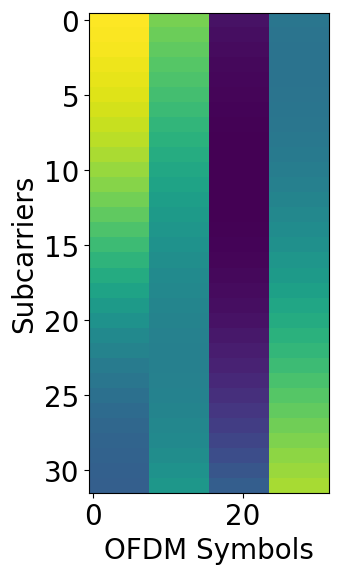

In [ ]:
from pprint import pprint
topology = download_and_load_pkl(
    "https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S",
    output="topology.pkl",
)

values_topology = list(load_topology(topology).values())
CHANNEL_MODEL.set_topology(*values_topology, None)
CHANNEL_MODEL.show_topology()
h_freq = sample_channel_1(1)
pprint(values_topology)

# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow(h_freq[0].reshape(32,32).real.T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [ ]:
def current_noise(signal, snr):
    snr = 10**(snr/10)

    # signal_power = np.abs(np.mean(signal**2))
    signal_power = 0.001

    noise_power = signal_power / snr

    noise = np.sqrt(noise_power) * (np.random.normal(size=signal.shape) + 1j*np.random.normal(size=signal.shape)) / np.sqrt(2)

    return noise

In [ ]:
from tqdm import tqdm
number_of_samples = 20000

responses = np.zeros(
    (number_of_samples, 4, num_ofdm_symbols, num_effective_subcarriers, 2)
)  # sample size x number_ant x num_ofdm_symbols x subcariers x 2
channels = np.zeros_like(
    responses
)   # sample size x number_ant x num_ofdm_symbols x subcariers x 2
pilots = np.zeros_like(responses)   # sample size x number_ant x num_ofdm_symbols x subcariers x 2
noises = np.zeros_like(responses)

for i in tqdm(range(number_of_samples)):
    h_freq = sample_channel_1(1)[0]
    response = h_freq * x_signal

    cur_noise = current_noise(response, snr=0)
    response = response + cur_noise

    responses[i, :, :, :, 0] = response.real
    responses[i, :, :, :, 1] = response.imag

    channels[i, :, :, :, 0] = h_freq.real
    channels[i, :, :, :, 1] = h_freq.imag

    pilots[i, :, :, :, 0] = x_signal.real
    pilots[i, :, :, :, 1] = x_signal.imag

    noises[i,:,:,:,0] = cur_noise.real
    noises[i,:,:,:,1] = cur_noise.imag


100%|██████████| 20000/20000 [2:12:56<00:00,  2.51it/s]


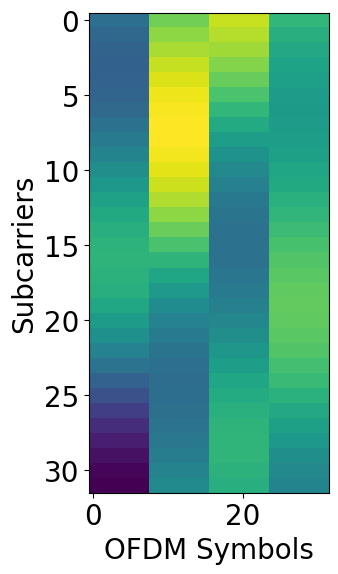

In [ ]:
# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow(channels[0,:,:,:,0].reshape(32, 32).T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

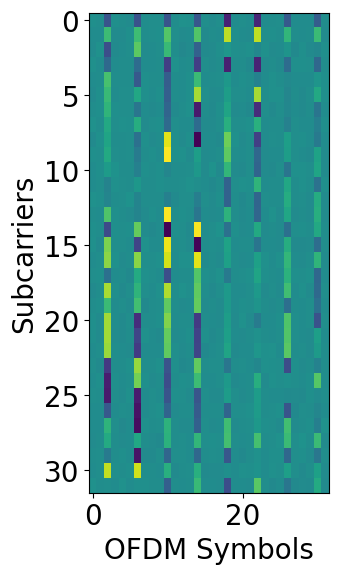

In [ ]:
# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow(responses[0,:,:,:,0].reshape(32,32).T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

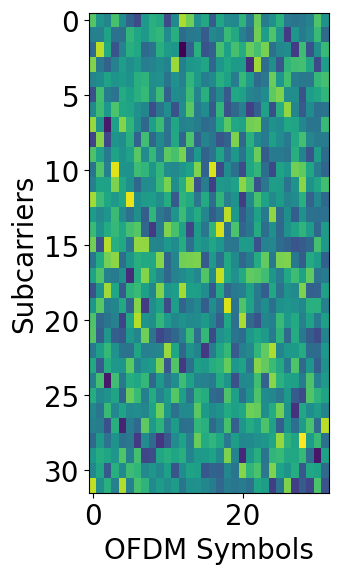

In [ ]:
# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow(noises[0,:,:,:,0].reshape(32,32).T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

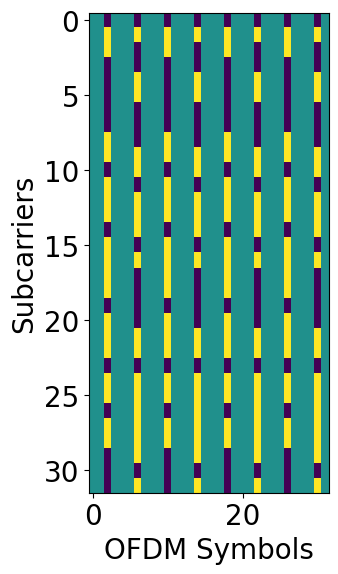

In [ ]:
# Display the array as an image
fig, ax = plt.subplots(figsize=(3, 6))  # Adjust the figsize to make the plot height much greater than the width
plt.imshow((pilots[0,:,:,:,0].reshape(32,32)).T, cmap='viridis', aspect='auto')

# Set labels for the axes with increased fontsize
plt.xlabel('OFDM Symbols', fontsize=20)
plt.ylabel('Subcarriers', fontsize=20)

# Adjust tick parameters to increase the size of tick labels
plt.tick_params(axis='both', which='major', labelsize=20)

# Adjust subplot parameters to fit the figure area
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

# Show the plot
plt.show()

In [ ]:
import pickle
import numpy as np

with open('channels.pkl', 'wb') as f:
    pickle.dump(channels, f)

with open('responses.pkl', 'wb') as f:
    pickle.dump(responses, f)

with open('pilots.pkl', 'wb') as f:
    pickle.dump(pilots, f)

with open('noises.pkl', 'wb') as f:
    pickle.dump(noises, f)

In [ ]:
channels.shape